<a href="https://colab.research.google.com/github/Seongjin1225/Capstone/blob/main/%EC%95%88%EA%B5%AC%EC%A7%88%ED%99%98_%EB%AA%A8%EB%8D%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 데이터 개요
1. 안검염
   - 유, 무 각각 1,200장
2. 결막염
   - 유, 무 각각 3,900
3. 각막부골편
   - 유, 무 각각 3,900
4. 비궤양성각막염
   - 유, 무 각각 1,500
5. 각막궤양
   - 유,무 각각 3,900장

## 각각의 데이터를 하나로 합쳐 레이블 지정 후 학습하는 형식으로 실행

# ResNet 50 Model

In [ ]:
# 필요 라이브러리 호출
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import cv2

from PIL import Image
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Activation, Dense, Conv2D, MaxPooling2D, BatchNormalization,GlobalAveragePooling2D, ZeroPadding2D, Add
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import ResNet50

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [ ]:
np.random.seed(42)
input_shape = (224,224,3)
num_class = 6

# 모델 호출

In [ ]:
model = ResNet50(weights='imagenet',input_shape = input_shape, include_top=False)
# model_base.trainable = False

# num = 1
# for layer in model_base.layers:
#     if num >= 3:
#         layer.trainable=True
#     else:
#         layer.trainable=False
#     num += 1

x = model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(num_class, activation='softmax')(x)

model = Model(inputs=model.input, outputs=predictions)

# 모델 요약 출력
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

In [ ]:
# /content/drive/MyDrive/종합설계/Train/안구/일반/각막궤양
# /content/drive/MyDrive/종합설계/Train/안구/일반/각막부골편
# /content/drive/MyDrive/종합설계/Train/안구/일반/결막염
# /content/drive/MyDrive/종합설계/Train/안구/일반/비궤양성각막염
# /content/drive/MyDrive/종합설계/Train/안구/일반/안검염

# Raw Data Loading

In [ ]:
# Train Data
from tqdm import tqdm
import pandas as pd
from pathlib import Path

folder_path = '/content/drive/MyDrive/종합설계/Train/안구/일반'

# 질병 목록 정의
diseases = ['각막궤양', '각막부골편', '결막염', '비궤양성각막염', '안검염']
disease_type = []

# 질병 폴더로부터 '유' 폴더의 경로를 disease_type에 추가
for disease in diseases:
    disease_path = Path(folder_path + '/' + disease + '/유')
    disease_type.append(disease_path)

# '무' 폴더를 처리하기 위한 별도의 리스트 생성 - 모든 '무' 폴더 루트
normal_images = []
for disease in diseases:
    normal_path = Path(folder_path + '/' + disease + '/무')
    normal_images.extend(list(normal_path.iterdir()))

# DataFrame 생성
df = pd.DataFrame()

# '유' 폴더 내 이미지 처리
for types in disease_type:
    for imagepath in tqdm(list(types.iterdir()), desc=str(types)):
        if str(imagepath).endswith('.jpg'):
            df = pd.concat([df, pd.DataFrame({'image': [str(imagepath)], 'disease_type': [disease_type.index(types)]})], ignore_index=True)

# '무' 폴더 내 이미지 처리
for imagepath in tqdm(normal_images, desc="Normal Images"):
    if str(imagepath).endswith('.jpg'):
        df = pd.concat([df, pd.DataFrame({'image': [str(imagepath)], 'disease_type': [5]})], ignore_index=True)


/content/drive/MyDrive/종합설계/Train/안구/일반/결막염/유: 100%|██████████| 6238/6238 [00:01<00:00, 3607.22it/s]
/content/drive/MyDrive/종합설계/Train/안구/일반/비궤양성각막염/유: 100%|██████████| 2384/2384 [00:00<00:00, 3456.46it/s]
Normal Images: 100%|██████████| 23032/23032 [00:07<00:00, 2909.64it/s]


In [ ]:
# Valid Data
from tqdm import tqdm
import pandas as pd
from pathlib import Path

folder_path = '/content/drive/MyDrive/종합설계/Valid/안구/일반'

# 질병 목록 정의
diseases = ['각막궤양', '각막부골편', '결막염', '비궤양성각막염', '안검염']
disease_type = []

# 질병 폴더로부터 '유' 폴더의 경로를 disease_type에 추가
for disease in diseases:
    disease_path = Path(folder_path + '/' + disease + '/유')
    disease_type.append(disease_path)

# '무' 폴더를 처리하기 위한 별도의 리스트 생성 - 모든 '무' 폴더 루트
normal_images = []
for disease in diseases:
    normal_path = Path(folder_path + '/' + disease + '/무')
    normal_images.extend(list(normal_path.iterdir()))

# DataFrame 생성
df_val = pd.DataFrame()

# '유' 폴더 내 이미지 처리
for types in disease_type:
    for imagepath in tqdm(list(types.iterdir()), desc=str(types)):
        if str(imagepath).endswith('.jpg'):
            df_val = pd.concat([df_val, pd.DataFrame({'image': [str(imagepath)], 'disease_type': [disease_type.index(types)]})], ignore_index=True)

# '무' 폴더 내 이미지 처리
for imagepath in tqdm(normal_images, desc="Normal Images"):
    if str(imagepath).endswith('.jpg'):
        df_val = pd.concat([df_val, pd.DataFrame({'image': [str(imagepath)], 'disease_type': [5]})], ignore_index=True)

df_val.tail()

/content/drive/MyDrive/종합설계/Valid/안구/일반/결막염/유: 100%|██████████| 792/792 [00:00<00:00, 3878.00it/s]
/content/drive/MyDrive/종합설계/Valid/안구/일반/비궤양성각막염/유: 100%|██████████| 310/310 [00:00<00:00, 4495.27it/s]
Normal Images: 100%|██████████| 2882/2882 [00:00<00:00, 3847.01it/s]


,image,disease_type
2913,/content/drive/MyDrive/종합설계/Valid/안구/일반/안검염/무/...,5
2914,/content/drive/MyDrive/종합설계/Valid/안구/일반/안검염/무/...,5
2915,/content/drive/MyDrive/종합설계/Valid/안구/일반/안검염/무/...,5
2916,/content/drive/MyDrive/종합설계/Valid/안구/일반/안검염/무/...,5
2917,/content/drive/MyDrive/종합설계/Valid/안구/일반/안검염/무/...,5


In [ ]:
# 정상 사진 개수 조절(질병 사진의 평균 -> 2,299장)
# 11495 -> 정상 사진 시작 인덱스
# df = df.iloc[:13795]
# len(df)
# df['disease_type'].value_counts().sort_index()

In [ ]:
df_train,df_test = train_test_split(df,test_size=0.2)
df_train['disease_type'] = df_train['disease_type'].astype(str)
df_test['disease_type'] = df_test['disease_type'].astype(str)
df_val['disease_type'] = df_val['disease_type'].astype(str)

# Data Augmentation

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_gen = ImageDataGenerator(rescale=1/255,
                               rotation_range=30,
                               width_shift_range=0.2,
                               height_shift_range=0.2,
                               shear_range=0.2,
                               zoom_range=0.2,
                               horizontal_flip=True,
                               fill_mode='nearest')

valid_gen = ImageDataGenerator(rescale=1/255)
test_gen = ImageDataGenerator(rescale=1/255)

train_generator = train_gen.flow_from_dataframe(df_train,
                                                directory=None,
                                                x_col='image',
                                                y_col='disease_type',
                                                target_size=(224,224),
                                                batch_size=256,
                                                class_mode='categorical')

valid_generator = valid_gen.flow_from_dataframe(df_test,
                                                directory=None,
                                                x_col='image',
                                                y_col='disease_type',
                                                target_size=(224,224),
                                                batch_size=256,
                                                class_mode='categorical')

test_generator = test_gen.flow_from_dataframe(df_val,
                                                directory=None,
                                                x_col='image',
                                                y_col='disease_type',
                                                target_size=(224,224),
                                                batch_size=256,
                                                class_mode='categorical')

/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1460: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, which overrides setting of `featurewise_center`.
  warnings.warn(


Found 18408 validated image filenames belonging to 6 classes.
Found 4603 validated image filenames belonging to 6 classes.
Found 2918 validated image filenames belonging to 6 classes.


# Model Training

In [ ]:
model.compile(optimizer=Adam(learning_rate=1e-2),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

es_cb = EarlyStopping(monitor='val_loss',
                      patience=5,
                      mode='max',  # min(손실감소), max(정확도 증가),
                      restore_best_weights=True,
                      verbose=1)

history = model.fit(train_generator,
                    steps_per_epoch=train_generator.samples//train_generator.batch_size,
                    epochs=10,
                    validation_data = valid_generator,
                    validation_steps=valid_generator.samples//valid_generator.batch_size,
                    verbose=1,
                    callbacks=[es_cb])

/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1862: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1872: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


Epoch 1/10
287/287 [==============================] - 2208s 8s/step - loss: 1.3616 - accuracy: 0.5382 - val_loss: 1.3236 - val_accuracy: 0.5385
Epoch 2/10
287/287 [==============================] - 277s 963ms/step - loss: 1.2751 - accuracy: 0.5533 - val_loss: 1.2552 - val_accuracy: 0.5502
Epoch 3/10
287/287 [==============================] - 275s 957ms/step - loss: 1.2444 - accuracy: 0.5618 - val_loss: 1.2243 - val_accuracy: 0.5588
Epoch 4/10
287/287 [==============================] - 277s 964ms/step - loss: 1.2257 - accuracy: 0.5647 - val_loss: 1.2563 - val_accuracy: 0.5515
Epoch 5/10
287/287 [==============================] - 274s 953ms/step - loss: 1.1979 - accuracy: 0.5727 - val_loss: 1.1945 - val_accuracy: 0.5735
Epoch 6/10
287/287 [==============================] - 273s 948ms/step - loss: 1.1557 - accuracy: 0.5861 - val_loss: 1.1361 - val_accuracy: 0.5878
Epoch 6: early stopping


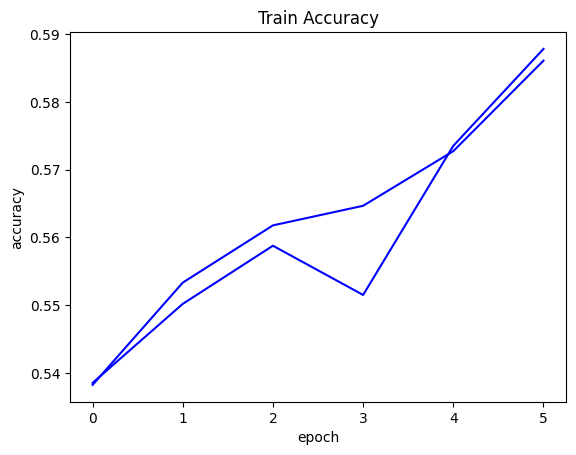

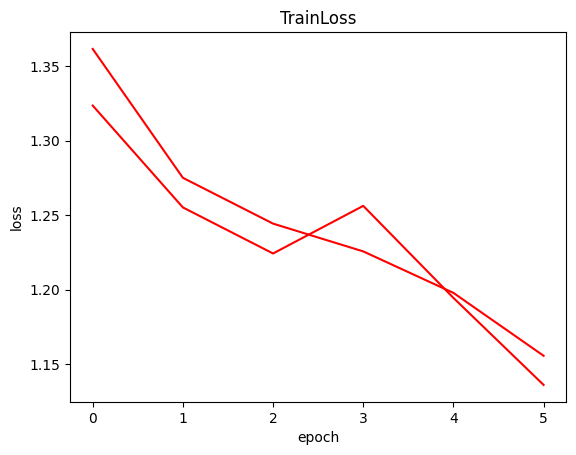

In [ ]:
# 데이터의 정확도를 기준으로한 그래프 작성
plt.plot(history.history['accuracy'],'b')
plt.plot(history.history['val_accuracy'],'b')
plt.title('Train Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()
# 데이터의 loss를 기준으로 그래프 작성
plt.plot(history.history['loss'],'r')
plt.plot(history.history['val_loss'],'r')
plt.title('TrainLoss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
# 모델 및 가중치 저장
# model.save("/content/drive/MyDrive/model.h5")
# model.save_weights("/content/drive/MyDrive/model_weight.h5")

In [ ]:
# ResNet50 모델
# def conv1_layer(x):
#     x = ZeroPadding2D(padding=(3,3))(x)
#     x = Conv2D(64,(7,7), strides=(2,2))(x)
#     x = BatchNormalization()(x)
#     x = Activation('relu')(x)
#     x = ZeroPadding2D(padding=(1,1))(x)

#     return x

# def conv2_layer(x):
#     x = MaxPooling2D((3,3), 2)(x)

#     shortcut = x

#     for i in range(3):
#         if i == 0:
#             x = Conv2D(64, (1,1), strides=(1,1), padding='valid')(x)
#             x = BatchNormalization()(x)
#             x = Activation('relu')(x)

#             x = Conv2D(64, (3,3), strides = (1,1), padding='same')(x)
#             x = BatchNormalization()(x)
#             x = Activation('relu')(x)

#             x = Conv2D(256, (1,1), strides=(1,1), padding= 'valid')(x)
#             shortcut = Conv2D(256, (1,1), strides=(1,1), padding='valid')(shortcut)
#             x = BatchNormalization()(x)
#             shortcut = BatchNormalization()(shortcut)

#             x = Add()([x, shortcut])
#             x = Activation('relu')(x)

#             shortcut = x
#         else:
#             x = Conv2D(64, (1,1), strides=(1,1), padding='valid')(x)
#             x = BatchNormalization()(x)
#             x = Activation('relu')(x)

#             x = Conv2D(64, (3,3), strides = (1,1), padding='same')(x)
#             x = BatchNormalization()(x)
#             x = Activation('relu')(x)

#             x = Conv2D(256, (1,1), strides=(1,1), padding='valid')(x)
#             x = BatchNormalization()(x)

#             x = Add()([x, shortcut])
#             x = Activation('relu')(x)

#             shortcut = x

#     return x

# def conv3_layer(x):
#     shortcut = x

#     for i in range(4):
#         if i == 0:
#             x = Conv2D(128, (1,1), strides=(2,2), padding='valid')(x)
#             x = BatchNormalization()(x)
#             x = Activation('relu')(x)

#             x = Conv2D(128, (3,3), strides=(1,1), padding='same')(x)
#             x = BatchNormalization()(x)
#             x = Activation('relu')(x)

#             x = Conv2D(512, (1,1), strides=(1,1), padding='valid')(x)
#             shortcut = Conv2D(512, (1,1), strides=(2,2), padding='valid')(shortcut)
#             x = BatchNormalization()(x)
#             shortcut = BatchNormalization()(shortcut)

#             x = Add()([x,shortcut])
#             x = Activation('relu')(x)

#             shortcut = x

#         else:
#             x = Conv2D(128, (1,1), strides=(2,2), padding='valid')(x)
#             x = BatchNormalization()(x)
#             x = Activation('relu')(x)

#             x = Conv2D(128, (3,3), strides=(1,1), padding='same')(x)
#             x = BatchNormalization(axis=-1)(x)
#             x = Activation('relu')(x)

#             x = Conv2D(512, (1,1), strides=(1,1), padding='valid')(x)
#             x = BatchNormalization()(x)

#             x = Add()([x, shortcut])
#             x = Activation('relu')(x)

#             shortcut = x

#     return x

# def conv4_layer(x):
#     shortcut = x

#     for i in range(6):
#         if i == 0:
#             x = Conv2D(256, (1,1), strides=(2,2), padding='valid')(x)
#             x = BatchNormalization()(x)
#             x = Activation('relu')(x)

#             x = Conv2D(256, (3,3), strides=(1,1), padding='same')(x)
#             x = BatchNormalization()(x)
#             x = Activation('relu')(x)

#             x = Conv2D(1024, (1,1), strides=(1,1), padding='valid')(x)
#             shortcut = Conv2D(1024, (1,1), strides=(2,2), padding='valid')(shortcut)
#             x = BatchNormalization()(x)
#             shortcut = BatchNormalization()(shortcut)

#             x = Add()([x, shortcut])
#             x = Activation('relu')(x)

#             shortcut = x

#         else:
#             x = Conv2D(256, (1,1), strides=(1,1), padding='valid')(x)
#             x = BatchNormalization()(x)
#             x = Activation('relu')(x)

#             x = Conv2D(256, (3,3), strides=(1,1), padding='same')(x)
#             x = BatchNormalization()(x)
#             x = Activation('relu')(x)

#             x = Conv2D(1024, (1, 1), strides=(1, 1), padding='valid')(x)
#             x = BatchNormalization()(x)

#             x = Add()([x, shortcut])
#             x = Activation('relu')(x)

#             shortcut = x

#     return x

# def conv5_layer(x):
#     shortcut = x

#     for i in range(3):
#         if(i == 0):
#             x = Conv2D(512, (1, 1), strides=(2, 2), padding='valid')(x)
#             x = BatchNormalization()(x)
#             x = Activation('relu')(x)

#             x = Conv2D(512, (3, 3), strides=(1, 1), padding='same')(x)
#             x = BatchNormalization()(x)
#             x = Activation('relu')(x)

#             x = Conv2D(2048, (1, 1), strides=(1, 1), padding='valid')(x)
#             shortcut = Conv2D(2048, (1, 1), strides=(2, 2), padding='valid')(shortcut)
#             x = BatchNormalization()(x)
#             shortcut = BatchNormalization()(shortcut)

#             x = Add()([x, shortcut])
#             x = Activation('relu')(x)

#             shortcut = x

#         else:
#             x = Conv2D(512, (1, 1), strides=(1, 1), padding='valid')(x)
#             x = BatchNormalization()(x)
#             x = Activation('relu')(x)

#             x = Conv2D(512, (3, 3), strides=(1, 1), padding='same')(x)
#             x = BatchNormalization()(x)
#             x = Activation('relu')(x)

#             x = Conv2D(2048, (1, 1), strides=(1, 1), padding='valid')(x)
#             x = BatchNormalization()(x)

#             x = Add()([x, shortcut])
#             x = Activation('relu')(x)

#             shortcut = x

#     return x


# def ResNet50(input_shape, num_classes):
#     inputs = Input(shape=input_shape)
#     x = conv1_layer(inputs)
#     x = conv2_layer(x)
#     x = conv3_layer(x)
#     x = conv4_layer(x)
#     x = conv5_layer(x)
#     x = GlobalAveragePooling2D()(x)
#     x = Dense(num_classes, activation='softmax')(x)
#     model = Model(input=inputs, outputs=x)
#     return model

In [ ]:
# # 데이터 경로
# data_dir = '/content/drive/MyDrive/종합설계/Train/안구/일반'
# category = ['유','무']

# # 이미지 데이터와 레이블 리스트 초기화
# images = []
# labels = []

# # 폴더 순회
# for folder in os.listdir(data_dir):
#     folder_path = os.path.join(data_dir, folder)

#     # 폴더 내 이미지 파일 순회
#     for filename in os.listdir(folder_path):
#         img_path = os.path.join(folder_path, filename)

#         # 이미지 로드 및 크기 조정
#         img = Image.open(img_path)
#         img = img.resize((224, 224))
#         img = np.array(img)

#         # 이미지와 레이블 추가
#         images.append(img)
#         labels.append(int(folder))

# # 이미지 데이터와 레이블을 NumPy 배열로 변환
# X = np.array(images)
# y = np.array(labels)




In [ ]:
# train_path = '/content/drive/MyDrive/종합설계/Train/안구/일반'
# categories = ['유','무']

# x1_t,y1_t = [],[]

# for idx, category in enumerate(categories):
#     label = [0 for _ in range(num_class)]
#     label[idx] = 1  # 원핫 인코딩(category가 '유' 인 경우 label = [1.0], '무'인 경우 label=[0.1])
#     train_dir = train_path + '/각막궤양/'+category+'/'

#     for top,dir, files in os.walk(train_dir):
#         for filename in files:
#             if filename[-4:] != 'json':
#                 img = cv2.imread(train_dir + filename,1)  # 1이 붙은 이유 -> RGB로 읽어오기 위해서
#                 img = cv2.resize(img,(200,200))
#                 img = cv2.copyMakeBorder(img,12,12,12,12,cv2.BORDER_CONSTANT, value=0)
#                 x1_t.append(img)
#                 y1_t.append(label)

# valid_path = '/content/drive/MyDrive/종합설계/Valid/안구/일반'
# categories = ['유','무']

# x1_v,y1_v = [],[]

# for idx, category in enumerate(categories):
#     label = [0 for _ in range(num_class)]
#     label[idx] = 1  # 원핫 인코딩(category가 '유' 인 경우 label = [1.0], '무'인 경우 label=[0.1])
#     valid_dir = valid_path + '/각막궤양/'+category+'/'

#     for top,dir, files in os.walk(valid_dir):
#         for filename in files:
#             if filename[-4:] != 'json':
#                 img = cv2.imread(valid_dir + filename,1)  # 1이 붙은 이유 -> RGB로 읽어오기 위해서
#                 img = cv2.resize(img,(200,200))
#                 img = cv2.copyMakeBorder(img,12,12,12,12,cv2.BORDER_CONSTANT, value=0)
#                 x1_v.append(img)
#                 y1_v.append(label)

GAN을 활용한 의료 영상 분석을 연구해보고 싶습니다. 현재 생성형 AI는 굉장한 화제가 되고 있고 그 기술 역시 끊임없이 발전하고 있습니다. 저는 이러한 GAN을 제 관심 연구 분야인 의료 영상 분석에 적용해보려고 합니다